This file implements the machine learning component of the final project. It works on already cleaned and preprocessed data and evaluates three machine learning models: Logistic Regression, Random Forest, and XGBClassifier from XGBoost. The notebook also addresses class imbalance using various techniques, tests multiple approaches, compares their performance, and visualizes the results. Finally, it identifies and selects the method that achieves the highest performance, providing a clear recommendation for the best-performing model.

In [39]:
import pandas as pd
import numpy as np
import logging
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from imblearn.over_sampling import SMOTE

from sklearn.metrics import (
    classification_report,
    accuracy_score,
    precision_score,
    recall_score,
    f1_score,
    roc_curve,
    auc,
    confusion_matrix
)

import os


In [40]:
data = pd.read_csv('data/data_updated.csv')

In [41]:
for handler in logging.root.handlers[:]:
    logging.root.removeHandler(handler)
logging.basicConfig(
    filename="logging/loggingML.log",
    level=logging.INFO,
    format='%(asctime)s %(levelname)s [%(filename)s:%(lineno)d] %(message)s'
)

loggerML = logging.getLogger()


In [42]:
X = data.drop(columns='Attrition')
y = data['Attrition']

# Identify categorical and numeric columns
categorical_cols = X.select_dtypes(include=['object', 'bool']).columns.tolist()
numeric_cols = X.select_dtypes(include=['int64', 'float64']).columns.tolist()

# Train-test split (unbalanced)
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

# Preprocessing: scale numeric, one-hot encode categorical
preprocessor = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), numeric_cols),
        ('cat', OneHotEncoder(drop='first', sparse_output=False), categorical_cols)
    ]
)

X_train = preprocessor.fit_transform(X_train)
X_test = preprocessor.transform(X_test)

loggerML.info('Data is ready for model evaluation')

In [43]:
#Logistic Regression on unbalanced data
UnbalancedModelLR = LogisticRegression(solver='lbfgs', max_iter=10000, random_state=42)
UnbalancedModelLR.fit(X_train, y_train)

UnbalancelR_pred = UnbalancedModelLR.predict(X_test)


print("LOGISTIC REGRESSION - UNBALANCED")
print("F1 score:", f1_score(y_test, UnbalancelR_pred))
print(classification_report(y_test, UnbalancelR_pred))

loggerML.info(f'Logistic Regression evaluated on unbalanced data F1 score {f1_score(y_test, UnbalancelR_pred)}')

LOGISTIC REGRESSION - UNBALANCED
F1 score: 0.4594594594594595
              precision    recall  f1-score   support

       False       0.89      0.96      0.92       247
        True       0.63      0.36      0.46        47

    accuracy                           0.86       294
   macro avg       0.76      0.66      0.69       294
weighted avg       0.85      0.86      0.85       294



we obviously see the terrible result and contrast in between accuracy and F1. accuracy is 0.88 while F1 score is 0.56, this is because our model mostly guess the majority class, so when minority class is prioritized, model performance drops

In [44]:
#Random Forest Classifier on unbalanced data
rf_unbal = RandomForestClassifier(
    n_estimators=200,
    max_depth=None,
    max_features='sqrt',
    random_state=42,
    n_jobs=-1
)
rf_unbal.fit(X_train, y_train)
y_pred_rf = rf_unbal.predict(X_test)

print("RANDOM FOREST - UNBALANCED")
print("F1 score:", f1_score(y_test, y_pred_rf))
print(classification_report(y_test, y_pred_rf))

loggerML.info(f'Random Forest Classifier evaluated on unbalanced data F1 score {f1_score(y_test, y_pred_rf)}')


RANDOM FOREST - UNBALANCED
F1 score: 0.13793103448275862
              precision    recall  f1-score   support

       False       0.85      0.97      0.91       247
        True       0.36      0.09      0.14        47

    accuracy                           0.83       294
   macro avg       0.61      0.53      0.52       294
weighted avg       0.77      0.83      0.78       294



In [45]:
smote = SMOTE(random_state=42)
X_train_sm, y_train_sm = smote.fit_resample(X_train, y_train)

# Logistic Regression with SMOTE
logreg_sm = LogisticRegression(solver='lbfgs', max_iter=10000, random_state=42)
logreg_sm.fit(X_train_sm, y_train_sm)
y_pred_sm_lr = logreg_sm.predict(X_test)

print("LOGISTIC REGRESSION - SMOTE")
print("F1 score:", f1_score(y_test, y_pred_sm_lr))
print(classification_report(y_test, y_pred_sm_lr))

loggerML.info(f'Logistic Regression evaluated with SMOTE F1 score {f1_score(y_test, y_pred_sm_lr)}')


rf_w = RandomForestClassifier(
    n_estimators=200,
    max_depth=None,
    max_features='sqrt',
    class_weight='balanced',
    random_state=42,
    n_jobs=-1
)
rf_w.fit(X_train, y_train)
y_pred_rf_w = rf_w.predict(X_test)

print("RANDOM FOREST - CLASS WEIGHTS")
print("F1 score:", f1_score(y_test, y_pred_rf_w))
print(classification_report(y_test, y_pred_rf_w))

loggerML.info(f'Random Forest evaluated with class weights F1 score {f1_score(y_test, y_pred_rf_w)}')

LOGISTIC REGRESSION - SMOTE
F1 score: 0.532258064516129
              precision    recall  f1-score   support

       False       0.94      0.82      0.88       247
        True       0.43      0.70      0.53        47

    accuracy                           0.80       294
   macro avg       0.68      0.76      0.70       294
weighted avg       0.85      0.80      0.82       294

RANDOM FOREST - CLASS WEIGHTS
F1 score: 0.10909090909090909
              precision    recall  f1-score   support

       False       0.85      0.98      0.91       247
        True       0.38      0.06      0.11        47

    accuracy                           0.83       294
   macro avg       0.61      0.52      0.51       294
weighted avg       0.77      0.83      0.78       294



Both SMOTE and custom class weights used for the experiment produced very poor results on the data set, which is very unbalanced; thus, I chose to continue my experiment on downsampling. SMOTE artificially creates new instances for the minority class to balance the data set, while the custom class weights tell the model to give more importance to the minority class during training.

In [46]:
#Since f1 scores are terrible we have to downsample the data so that output of 1 and 0 are almost same so that models are trained better
# Downsample majority class
minority = data[data['Attrition'] == True]
majority = data[data['Attrition'] == False]
majority_downsampled = majority.sample(n=int(len(minority)*1.1), random_state=42)
balanced_data = pd.concat([minority, majority_downsampled]).sample(frac=1, random_state=42)

# Features and target
X_bal = balanced_data.drop(columns='Attrition')
y_bal = balanced_data['Attrition']

# Train-test split
X_train_bal, X_test_bal, y_train_bal, y_test_bal = train_test_split(
    X_bal, y_bal, test_size=0.2, random_state=42, stratify=y_bal
)

# Preprocessing
X_train_bal = preprocessor.fit_transform(X_train_bal)
X_test_bal = preprocessor.transform(X_test_bal)


loggerML.info('The data was successfully downsampled for better evaluation')

In [47]:
# Logistic Regression on balanced data
logreg_bal = LogisticRegression(
    solver='lbfgs',
    max_iter=10000,
    random_state=42
)
logreg_bal.fit(X_train_bal, y_train_bal)
y_pred_bal = logreg_bal.predict(X_test_bal)

print("LOGISTIC REGRESSION - BALANCED")
print("F1 score:", f1_score(y_test_bal, y_pred_bal))
print(classification_report(y_test_bal, y_pred_bal))


loggerML.info(f'Logistic Regression evaluated on balanced data F1 score {f1_score(y_test_bal, y_pred_bal)}')

LOGISTIC REGRESSION - BALANCED
F1 score: 0.7021276595744681
              precision    recall  f1-score   support

       False       0.72      0.75      0.74        52
        True       0.72      0.69      0.70        48

    accuracy                           0.72       100
   macro avg       0.72      0.72      0.72       100
weighted avg       0.72      0.72      0.72       100



In [48]:
# Random Forest Classifier on balanced data
rf_bal = RandomForestClassifier(
    n_estimators=200,
    max_depth=None,
    max_features='sqrt',
    random_state=42,
    n_jobs=-1
)
rf_bal.fit(X_train_bal, y_train_bal)
y_pred_rf_bal = rf_bal.predict(X_test_bal)

print("RANDOM FOREST - BALANCED")
print("F1 score:", f1_score(y_test_bal, y_pred_rf_bal))
print(classification_report(y_test_bal, y_pred_rf_bal))

loggerML.info(f'Random Forest Classifier evaluated on balanced data F1 score {f1_score(y_test_bal, y_pred_rf_bal)}')


RANDOM FOREST - BALANCED
F1 score: 0.8
              precision    recall  f1-score   support

       False       0.81      0.83      0.82        52
        True       0.81      0.79      0.80        48

    accuracy                           0.81       100
   macro avg       0.81      0.81      0.81       100
weighted avg       0.81      0.81      0.81       100



In [49]:
#XGBoost on unbalanced data
xgb_unbal = XGBClassifier(
    n_estimators=200,
    max_depth=5,
    learning_rate=0.1,
    use_label_encoder=False,
    eval_metric='logloss',
    random_state=42
)
xgb_unbal.fit(X_train, y_train)
y_pred_xgb = xgb_unbal.predict(X_test)

print("XGBOOST - UNBALANCED")
print("F1 score:", f1_score(y_test, y_pred_xgb))
print(classification_report(y_test, y_pred_xgb))

loggerML.info(f'XGBoost evaluated on unbalanced data F1 score {f1_score(y_test, y_pred_xgb)}')


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:199: UserWarning: [17:54:47] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


XGBOOST - UNBALANCED
F1 score: 0.375
              precision    recall  f1-score   support

       False       0.87      0.98      0.92       247
        True       0.71      0.26      0.38        47

    accuracy                           0.86       294
   macro avg       0.79      0.62      0.65       294
weighted avg       0.85      0.86      0.84       294



In [50]:
#XGBoost on balanced data
xgb_bal = XGBClassifier(
    n_estimators=200,
    max_depth=5,
    learning_rate=0.1,
    use_label_encoder=False,
    eval_metric='logloss',
    random_state=42
)
xgb_bal.fit(X_train_bal, y_train_bal)
y_pred_xgb_bal = xgb_bal.predict(X_test_bal)

print("XGBOOST - BALANCED")
print("F1 score:", f1_score(y_test_bal, y_pred_xgb_bal))
print(classification_report(y_test_bal, y_pred_xgb_bal))

loggerML.info(f'XGBoost evaluated on balanced data F1 score {f1_score(y_test_bal, y_pred_xgb_bal)}')

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:199: UserWarning: [17:54:47] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


XGBOOST - BALANCED
F1 score: 0.782608695652174
              precision    recall  f1-score   support

       False       0.79      0.85      0.81        52
        True       0.82      0.75      0.78        48

    accuracy                           0.80       100
   macro avg       0.80      0.80      0.80       100
weighted avg       0.80      0.80      0.80       100



In [51]:
models_balanced = [
    ("Logistic_Regression", logreg_bal, X_test_bal, y_test_bal),
    ("Random_Forest", rf_bal, X_test_bal, y_test_bal),
    ("XGBoost", xgb_bal, X_test_bal, y_test_bal)
]

for name, model, X_test_model, y_test_model in models_balanced:
    y_pred = model.predict(X_test_model)

    f1 = f1_score(y_test_model, y_pred)
    report = classification_report(y_test_model, y_pred)

    with open(f"reports/results/{name}_balanced_results.txt", "w") as f:
        f.write(f"{name} - BALANCED\n")
        f.write(f"F1 score: {f1}\n\n")
        f.write(report)

    loggerML.info(f"{name} evaluated on balanced data F1 score {f1}")

In [52]:
metrics_dict = {}

y_pred = UnbalancelR_pred
metrics_dict["Logistic Regression (Unbalanced)"] = {
    "Accuracy": accuracy_score(y_test, y_pred),
    "Precision": precision_score(y_test, y_pred),
    "Recall": recall_score(y_test, y_pred),
    "F1 Score": f1_score(y_test, y_pred)
}

y_pred = y_pred_rf
metrics_dict["Random Forest (Unbalanced)"] = {
    "Accuracy": accuracy_score(y_test, y_pred),
    "Precision": precision_score(y_test, y_pred),
    "Recall": recall_score(y_test, y_pred),
    "F1 Score": f1_score(y_test, y_pred)
}

y_pred = y_pred_xgb
metrics_dict["XGBoost (Unbalanced)"] = {
    "Accuracy": accuracy_score(y_test, y_pred),
    "Precision": precision_score(y_test, y_pred),
    "Recall": recall_score(y_test, y_pred),
    "F1 Score": f1_score(y_test, y_pred)
}


y_pred = y_pred_bal
metrics_dict["Logistic Regression (Balanced)"] = {
    "Accuracy": accuracy_score(y_test_bal, y_pred),
    "Precision": precision_score(y_test_bal, y_pred),
    "Recall": recall_score(y_test_bal, y_pred),
    "F1 Score": f1_score(y_test_bal, y_pred)
}


y_pred = y_pred_rf_bal
metrics_dict["Random Forest (Balanced)"] = {
    "Accuracy": accuracy_score(y_test_bal, y_pred),
    "Precision": precision_score(y_test_bal, y_pred),
    "Recall": recall_score(y_test_bal, y_pred),
    "F1 Score": f1_score(y_test_bal, y_pred)
}


y_pred = y_pred_xgb_bal
metrics_dict["XGBoost (Balanced)"] = {
    "Accuracy": accuracy_score(y_test_bal, y_pred),
    "Precision": precision_score(y_test_bal, y_pred),
    "Recall": recall_score(y_test_bal, y_pred),
    "F1 Score": f1_score(y_test_bal, y_pred)
}


metrics_df = pd.DataFrame(metrics_dict).T

# Sort by F1 Score (most important metric for imbalance)
metrics_df = metrics_df.sort_values(by="F1 Score", ascending=False)

print(metrics_df)



                                  Accuracy  Precision    Recall  F1 Score
Random Forest (Balanced)          0.810000   0.808511  0.791667  0.800000
XGBoost (Balanced)                0.800000   0.818182  0.750000  0.782609
Logistic Regression (Balanced)    0.720000   0.717391  0.687500  0.702128
Logistic Regression (Unbalanced)  0.863946   0.629630  0.361702  0.459459
XGBoost (Unbalanced)              0.863946   0.705882  0.255319  0.375000
Random Forest (Unbalanced)        0.829932   0.363636  0.085106  0.137931


In [53]:
comparison_table = metrics_df[
    ['Accuracy', 'Precision', 'Recall', 'F1 Score']
].sort_values(by='F1 Score', ascending=False)

print(comparison_table)

# Identify best model based on F1 Score
best_model_name = comparison_table.index[0]
print(f"Best model based on F1 Score: {best_model_name}")

                                  Accuracy  Precision    Recall  F1 Score
Random Forest (Balanced)          0.810000   0.808511  0.791667  0.800000
XGBoost (Balanced)                0.800000   0.818182  0.750000  0.782609
Logistic Regression (Balanced)    0.720000   0.717391  0.687500  0.702128
Logistic Regression (Unbalanced)  0.863946   0.629630  0.361702  0.459459
XGBoost (Unbalanced)              0.863946   0.705882  0.255319  0.375000
Random Forest (Unbalanced)        0.829932   0.363636  0.085106  0.137931
Best model based on F1 Score: Random Forest (Balanced)


F1 score was chosen as the primary evaluation metric because of a strong class imbalance. The models trained with unbalanced data got a high accuracy and very low recall and F1 scores; this meant very few detections were made by the model on the employees that left the company. Balancing of the dataset was extremely helpful to achieve improved results. Random Forest (Balanced) gave the highest F1 score of 0.80 among the models tested because it can model nonlinear relationships and handle feature interactions and is less sensitive to noise and class imbalance as compared to linear models. The balanced version of XGBoost also performed decently, but given that recall was higher for Random Forest, it was able to identify attrition cases better.
Overall Random Forest with balanced training data worked best, having achieved a balance between precision and recall targeted at the minority group.


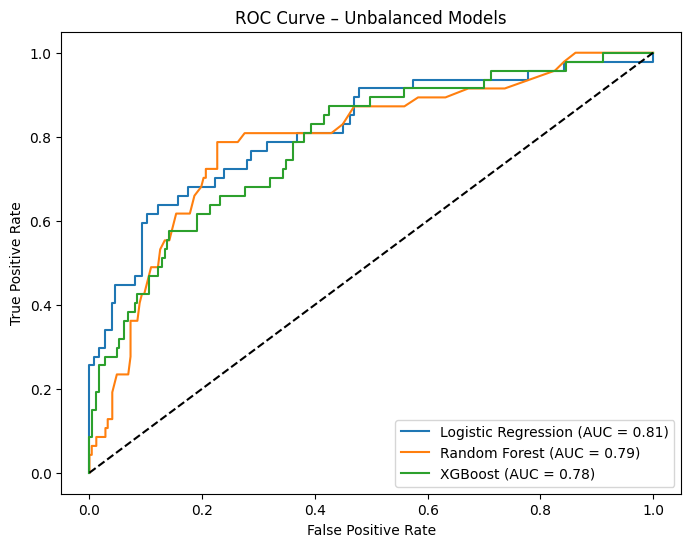

<Figure size 800x600 with 0 Axes>

<Figure size 800x600 with 0 Axes>

In [54]:
plt.figure(figsize=(8, 6))

# Logistic Regression - Unbalanced
y_prob_lr = UnbalancedModelLR.predict_proba(X_test)[:, 1]
fpr_lr, tpr_lr, _ = roc_curve(y_test, y_prob_lr)
roc_auc_lr = auc(fpr_lr, tpr_lr)
plt.plot(fpr_lr, tpr_lr, label=f'Logistic Regression (AUC = {roc_auc_lr:.2f})')

# Random Forest - Unbalanced
y_prob_rf = rf_unbal.predict_proba(X_test)[:, 1]
fpr_rf, tpr_rf, _ = roc_curve(y_test, y_prob_rf)
roc_auc_rf = auc(fpr_rf, tpr_rf)
plt.plot(fpr_rf, tpr_rf, label=f'Random Forest (AUC = {roc_auc_rf:.2f})')

# XGBoost - Unbalanced
y_prob_xgb = xgb_unbal.predict_proba(X_test)[:, 1]
fpr_xgb, tpr_xgb, _ = roc_curve(y_test, y_prob_xgb)
roc_auc_xgb = auc(fpr_xgb, tpr_xgb)
plt.plot(fpr_xgb, tpr_xgb, label=f'XGBoost (AUC = {roc_auc_xgb:.2f})')

# Random baseline
plt.plot([0, 1], [0, 1], 'k--')

plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve – Unbalanced Models')
plt.legend(loc='lower right')
plt.show()
plt.figure(figsize=(8, 6))

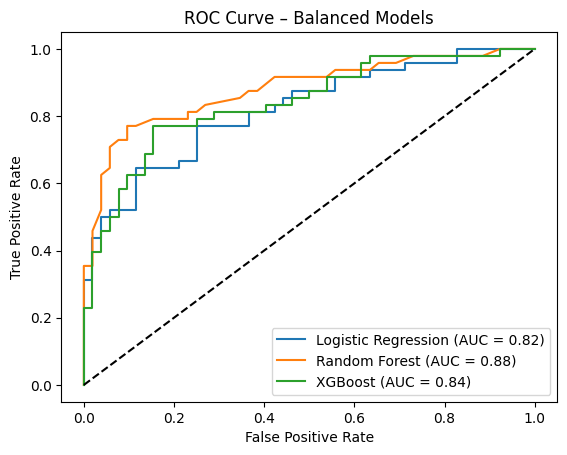

In [55]:

# Logistic Regression - Balanced
y_prob_lr_bal = logreg_bal.predict_proba(X_test_bal)[:, 1]
fpr_lr_bal, tpr_lr_bal, _ = roc_curve(y_test_bal, y_prob_lr_bal)
roc_auc_lr_bal = auc(fpr_lr_bal, tpr_lr_bal)
plt.plot(fpr_lr_bal, tpr_lr_bal, label=f'Logistic Regression (AUC = {roc_auc_lr_bal:.2f})')

# Random Forest - Balanced
y_prob_rf_bal = rf_bal.predict_proba(X_test_bal)[:, 1]
fpr_rf_bal, tpr_rf_bal, _ = roc_curve(y_test_bal, y_prob_rf_bal)
roc_auc_rf_bal = auc(fpr_rf_bal, tpr_rf_bal)
plt.plot(fpr_rf_bal, tpr_rf_bal, label=f'Random Forest (AUC = {roc_auc_rf_bal:.2f})')

# XGBoost - Balanced
y_prob_xgb_bal = xgb_bal.predict_proba(X_test_bal)[:, 1]
fpr_xgb_bal, tpr_xgb_bal, _ = roc_curve(y_test_bal, y_prob_xgb_bal)
roc_auc_xgb_bal = auc(fpr_xgb_bal, tpr_xgb_bal)
plt.plot(fpr_xgb_bal, tpr_xgb_bal, label=f'XGBoost (AUC = {roc_auc_xgb_bal:.2f})')

# Random baseline
plt.plot([0, 1], [0, 1], 'k--')

plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve – Balanced Models')
plt.legend(loc='lower right')
plt.show()

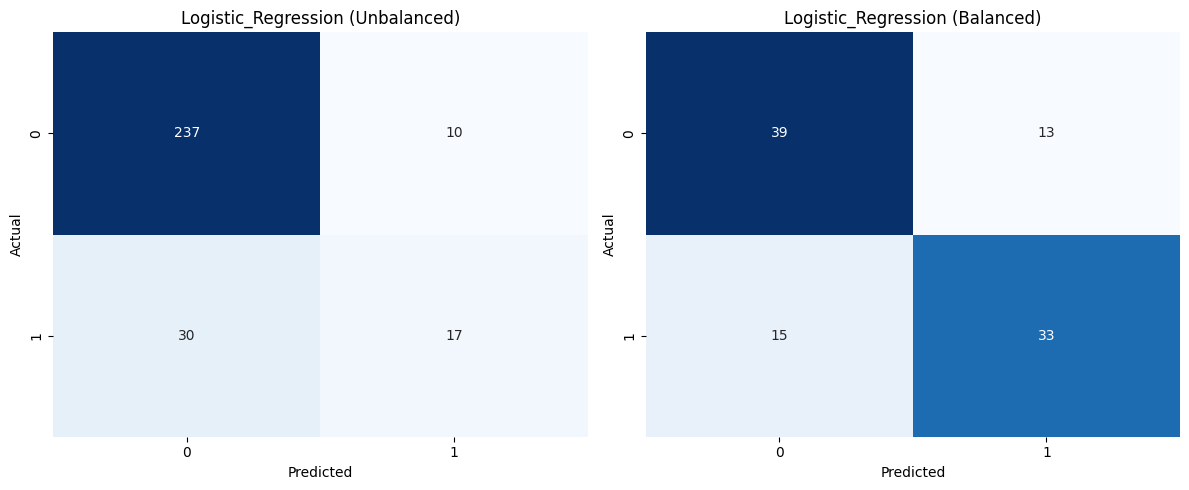

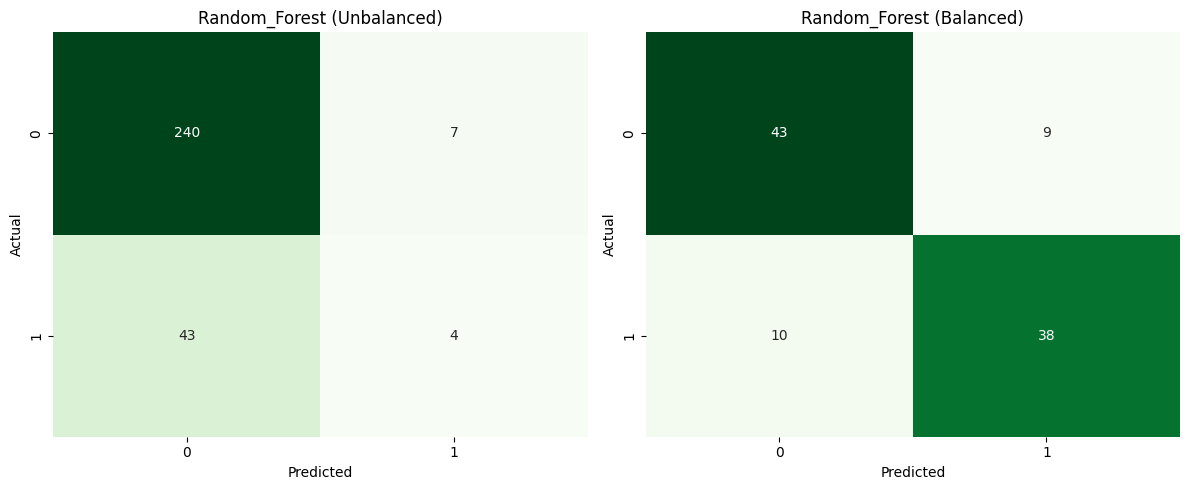

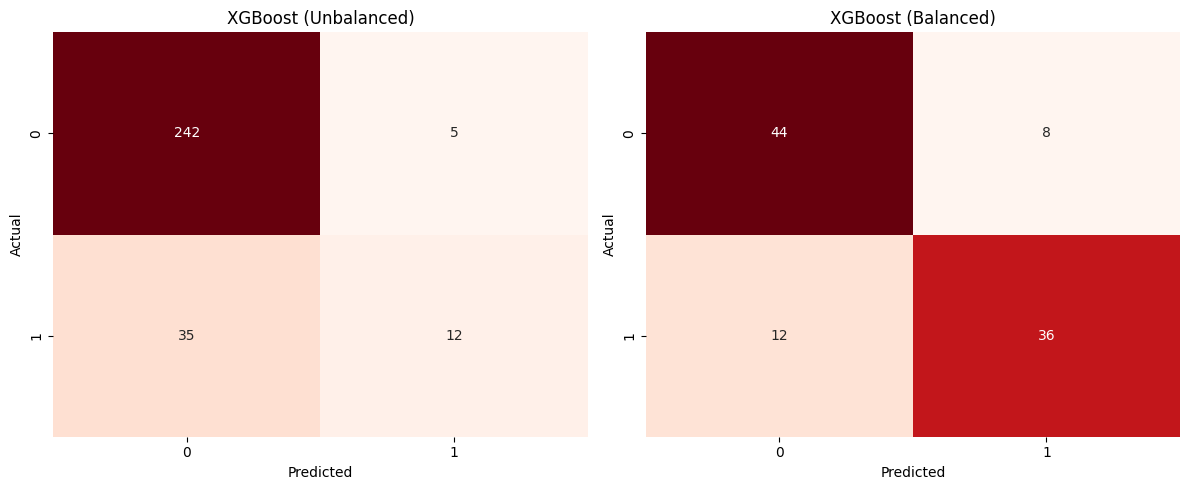

In [56]:
os.makedirs("reports/results", exist_ok=True)

models = [
    ("Logistic_Regression", UnbalancedModelLR, logreg_bal, X_test, y_test, X_test_bal, y_test_bal, "Blues"),
    ("Random_Forest", rf_unbal, rf_bal, X_test, y_test, X_test_bal, y_test_bal, "Greens"),
    ("XGBoost", xgb_unbal, xgb_bal, X_test, y_test, X_test_bal, y_test_bal, "Reds")
]

for name, unbal_model, bal_model, X_unbal, y_unbal, X_bal, y_bal, cmap in models:
    plt.figure(figsize=(12, 5))

    cm_unbal = confusion_matrix(y_unbal, unbal_model.predict(X_unbal))
    plt.subplot(1, 2, 1)
    sns.heatmap(cm_unbal, annot=True, fmt='d', cmap=cmap, cbar=False)
    plt.title(f'{name} (Unbalanced)')
    plt.xlabel('Predicted')
    plt.ylabel('Actual')

    cm_bal = confusion_matrix(y_bal, bal_model.predict(X_bal))
    plt.subplot(1, 2, 2)
    sns.heatmap(cm_bal, annot=True, fmt='d', cmap=cmap, cbar=False)
    plt.title(f'{name} (Balanced)')
    plt.xlabel('Predicted')
    plt.ylabel('Actual')

    plt.tight_layout()

    plt.savefig(f"reports/results/{name}_confusion_matrices.png", dpi=300)

    plt.show()


In [57]:
with open("logging/logging_combined.log", "w") as outfile:
    for fname in ["logging/logging_data_analysis.log", "logging/loggingML.log"]:
        with open(fname, "r") as infile:
            outfile.write(infile.read())
            outfile.write("\n")
